# Lab10: Word2Vec

link: https://nthu-datalab.github.io/ml/labs/10_Word2Vec/10_Word2Vec.html

112501533 黃思誠


## Import Library


In [1]:
import collections
import os
import urllib
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.layers import InputLayer, Layer


In [2]:
# Some constants
VOCABULARY_SIZE = 50000
DOWNLOAD_URL = "http://mattmahoney.net/dc/"
DATA_PATH = "./data"
FILE_NAME = "text8.zip"
EXPECTED_BYTES = 31344016


In [3]:
# Hyper-parameters
params = {
    "training_steps": 40000,
    "skip_step": 2000,
    "batch_size": 512,
    "embed_size": 512,
    "num_sampled": 256,
    "learning_rate": 1.0,
}


## Download & Get dataset dictionary


### Function for download and loading


In [4]:
# Download the dataset
def download(file_name, expected_bytes):
    """Download the dataset text8 if it's not already downloaded"""
    local_file_path = os.path.join(DATA_PATH, file_name)
    if os.path.exists(local_file_path):
        print("Dataset ready")
        return local_file_path
    file_name, _ = urllib.request.urlretrieve(
        os.path.join(DOWNLOAD_URL, file_name), local_file_path
    )
    file_stat = os.stat(local_file_path)
    if file_stat.st_size == expected_bytes:
        print("Successfully downloaded the file", file_name)
    else:
        raise Exception(
            "File "
            + file_name
            + " might be corrupted. You should try downloading it with a browser."
        )
    return local_file_path


# Read the data into a list of strings.
def read_data(file_path):
    """Read data into a list of tokens"""
    with zipfile.ZipFile(file_path) as f:
        # tf.compat.as_str() converts the input into string
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
    """Create two dictionaries and count of occuring words
    - word_to_id: map of words to their codes
    - id_to_word: maps codes to words (inverse word_to_id)
    - count: map of words to count of occurrences
    """
    # map unknown words to -1
    count = [["UNK", -1]]
    # count of occurences for words in vocabulary
    count.extend(collections.Counter(words).most_common(n_words - 1))
    word_to_id = dict()  # (word, id)
    # record word id
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))  # (id, word)
    return word_to_id, id_to_word, count


### Function for generate dataset dictionary


In [5]:
def convert_words_to_id(words, dictionary, count):
    """Replace each word in the dataset with its index in the dictionary"""
    data_w2id = []
    unk_count = 0
    for word in words:
        # return 0 if word is not in dictionary
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data_w2id.append(index)
    count[0][1] = unk_count
    return data_w2id, count


# utility function
def generate_sample(center_words, context_window_size):
    """Form training pairs according to the skip-gram model."""
    for idx, center in enumerate(center_words):
        context = np.random.randint(1, context_window_size)
        # get a random target before the center word
        for target in center_words[max(0, idx - context) : idx]:
            yield center, target
        # get a random target after the center word
        for target in center_words[idx + 1 : idx + context + 1]:
            yield center, target


def batch_generator(data, skip_window, batch_size):
    """Group a numeric stream into batches and yield them as Numpy arrays."""
    single_gen = generate_sample(data, skip_window)
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for idx in range(batch_size):
            center_batch[idx], target_batch[idx] = next(single_gen)
        yield center_batch, target_batch


In [6]:
# Create data directory
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Get the dataset
vocabulary = read_data(download(FILE_NAME, EXPECTED_BYTES))
word_to_id, id_to_word, count = build_dataset(vocabulary, VOCABULARY_SIZE)
data_w2id, count = convert_words_to_id(vocabulary, word_to_id, count)
del vocabulary  # reduce memory.


Dataset ready


## Construct the model


### Define the layers


In [7]:
# embedding matrix - hidden layer
class embedding_lookup(Layer):
    def __init__(self, embed_size):
        super(embedding_lookup, self).__init__()
        embedding_init = tf.keras.initializers.GlorotUniform()
        self.embedding_matrix = self.add_weight(
            name="embedding_matrix",
            trainable=True,
            shape=[VOCABULARY_SIZE, embed_size],
            initializer=embedding_init,
        )

    def call(self, inputs):
        center_words = inputs
        embedding = tf.nn.embedding_lookup(
            self.embedding_matrix, center_words, name="embedding"
        )
        return embedding


# context matrix - prediction layer
class nce_loss(Layer):
    def __init__(self, embed_size, num_sampled):
        super(nce_loss, self).__init__()
        self.embed_size = embed_size
        self.num_sampled = num_sampled

        nce_w_init = tf.keras.initializers.TruncatedNormal(
            stddev=1.0 / (embed_size**0.5)
        )
        self.nce_weight = self.add_weight(
            name="nce_weight",
            trainable=True,
            shape=[VOCABULARY_SIZE, self.embed_size],
            initializer=nce_w_init,
        )
        self.nce_bias = self.add_weight(
            name="nce_bias",
            trainable=True,
            shape=[VOCABULARY_SIZE],
            initializer=tf.keras.initializers.Zeros,
        )

    def call(self, inputs):
        embedding, target_words = inputs[0], inputs[1]
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=self.nce_weight,
                biases=self.nce_bias,
                labels=target_words,
                inputs=embedding,
                num_sampled=self.num_sampled,
                num_classes=VOCABULARY_SIZE,
            ),
            name="loss",
        )
        return loss


### Define the model


In [8]:
class Word2Vec(Model):
    def __init__(
        self,
        embed_size=512,
        num_sampled=256,
    ):
        """To-Do: Define model variables"""
        super(Word2Vec, self).__init__()
        self.embed_size = embed_size
        self.num_sampled = num_sampled

        # define model structure
        self.center_words = InputLayer(
            input_shape=(), name="center_words", dtype=tf.int32
        )
        self.target_words = InputLayer(
            input_shape=(1,), name="target_words", dtype=tf.int32
        )

        self.embedding = embedding_lookup(self.embed_size)
        self.loss = nce_loss(self.embed_size, self.num_sampled)

    def call(self, inputs):
        """To-Do: Define data flow and return loss"""
        center_words, target_words = inputs[0], inputs[1]
        center_words = self.center_words(inputs[0])
        target_words = self.target_words(inputs[1])

        embedding = self.embedding(center_words)
        loss = self.loss([embedding, target_words])

        return loss


### Consruct model, loss, optimizer


In [9]:
word2vec = Word2Vec(embed_size=params["embed_size"], num_sampled=params["num_sampled"])
train_loss = tf.keras.metrics.Mean(name="train_loss")
optimizer = tf.keras.optimizers.legacy.SGD(
    learning_rate=params["learning_rate"], momentum=0.1, nesterov=True
)


## Train the model


### Create tensorflow dataset


In [10]:
def gen():
    yield from batch_generator(data_w2id, 2, params["batch_size"])


dataset = tf.data.Dataset.from_generator(
    gen,
    (tf.int32, tf.int32),
    (tf.TensorShape([params["batch_size"]]), tf.TensorShape([params["batch_size"], 1])),
).repeat()


### Training


In [11]:
# Define training function
@tf.function
def train_step(center_words, target_words):
    with tf.GradientTape() as tape:
        loss = word2vec([center_words, target_words])

    gradients = tape.gradient(loss, word2vec.trainable_variables)
    optimizer.apply_gradients(zip(gradients, word2vec.trainable_variables))

    train_loss(loss)


# Training
x = []
y = []
for step, (center_words, target_words) in enumerate(dataset):
    if step == params["training_steps"]:
        break
    train_step(center_words, target_words)

    if ((step + 1) % params["skip_step"]) == 0:
        template = "Step {:0}, Loss: {:.2f}"
        x.append(step + 1)
        y.append(train_loss.result())
        print(template.format(step + 1, train_loss.result()))
        train_loss.reset_states()


Step 2000, Loss: 172.65
Step 4000, Loss: 28.96
Step 6000, Loss: 12.85
Step 8000, Loss: 9.92
Step 10000, Loss: 8.21
Step 12000, Loss: 7.55
Step 14000, Loss: 7.09
Step 16000, Loss: 6.83
Step 18000, Loss: 6.53
Step 20000, Loss: 6.43
Step 22000, Loss: 6.34
Step 24000, Loss: 6.20
Step 26000, Loss: 6.10
Step 28000, Loss: 6.05
Step 30000, Loss: 5.85
Step 32000, Loss: 5.86
Step 34000, Loss: 5.79
Step 36000, Loss: 5.81
Step 38000, Loss: 5.72
Step 40000, Loss: 5.82


## Plot the loss curve


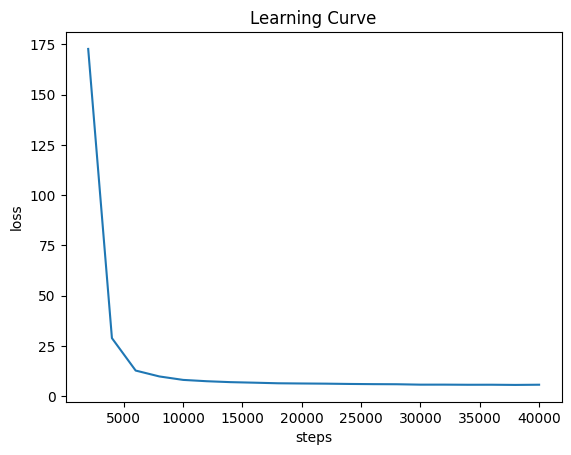

In [12]:
%matplotlib inline

plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.plot(x, y)
plt.show()


## Visualizing the learned embeddings


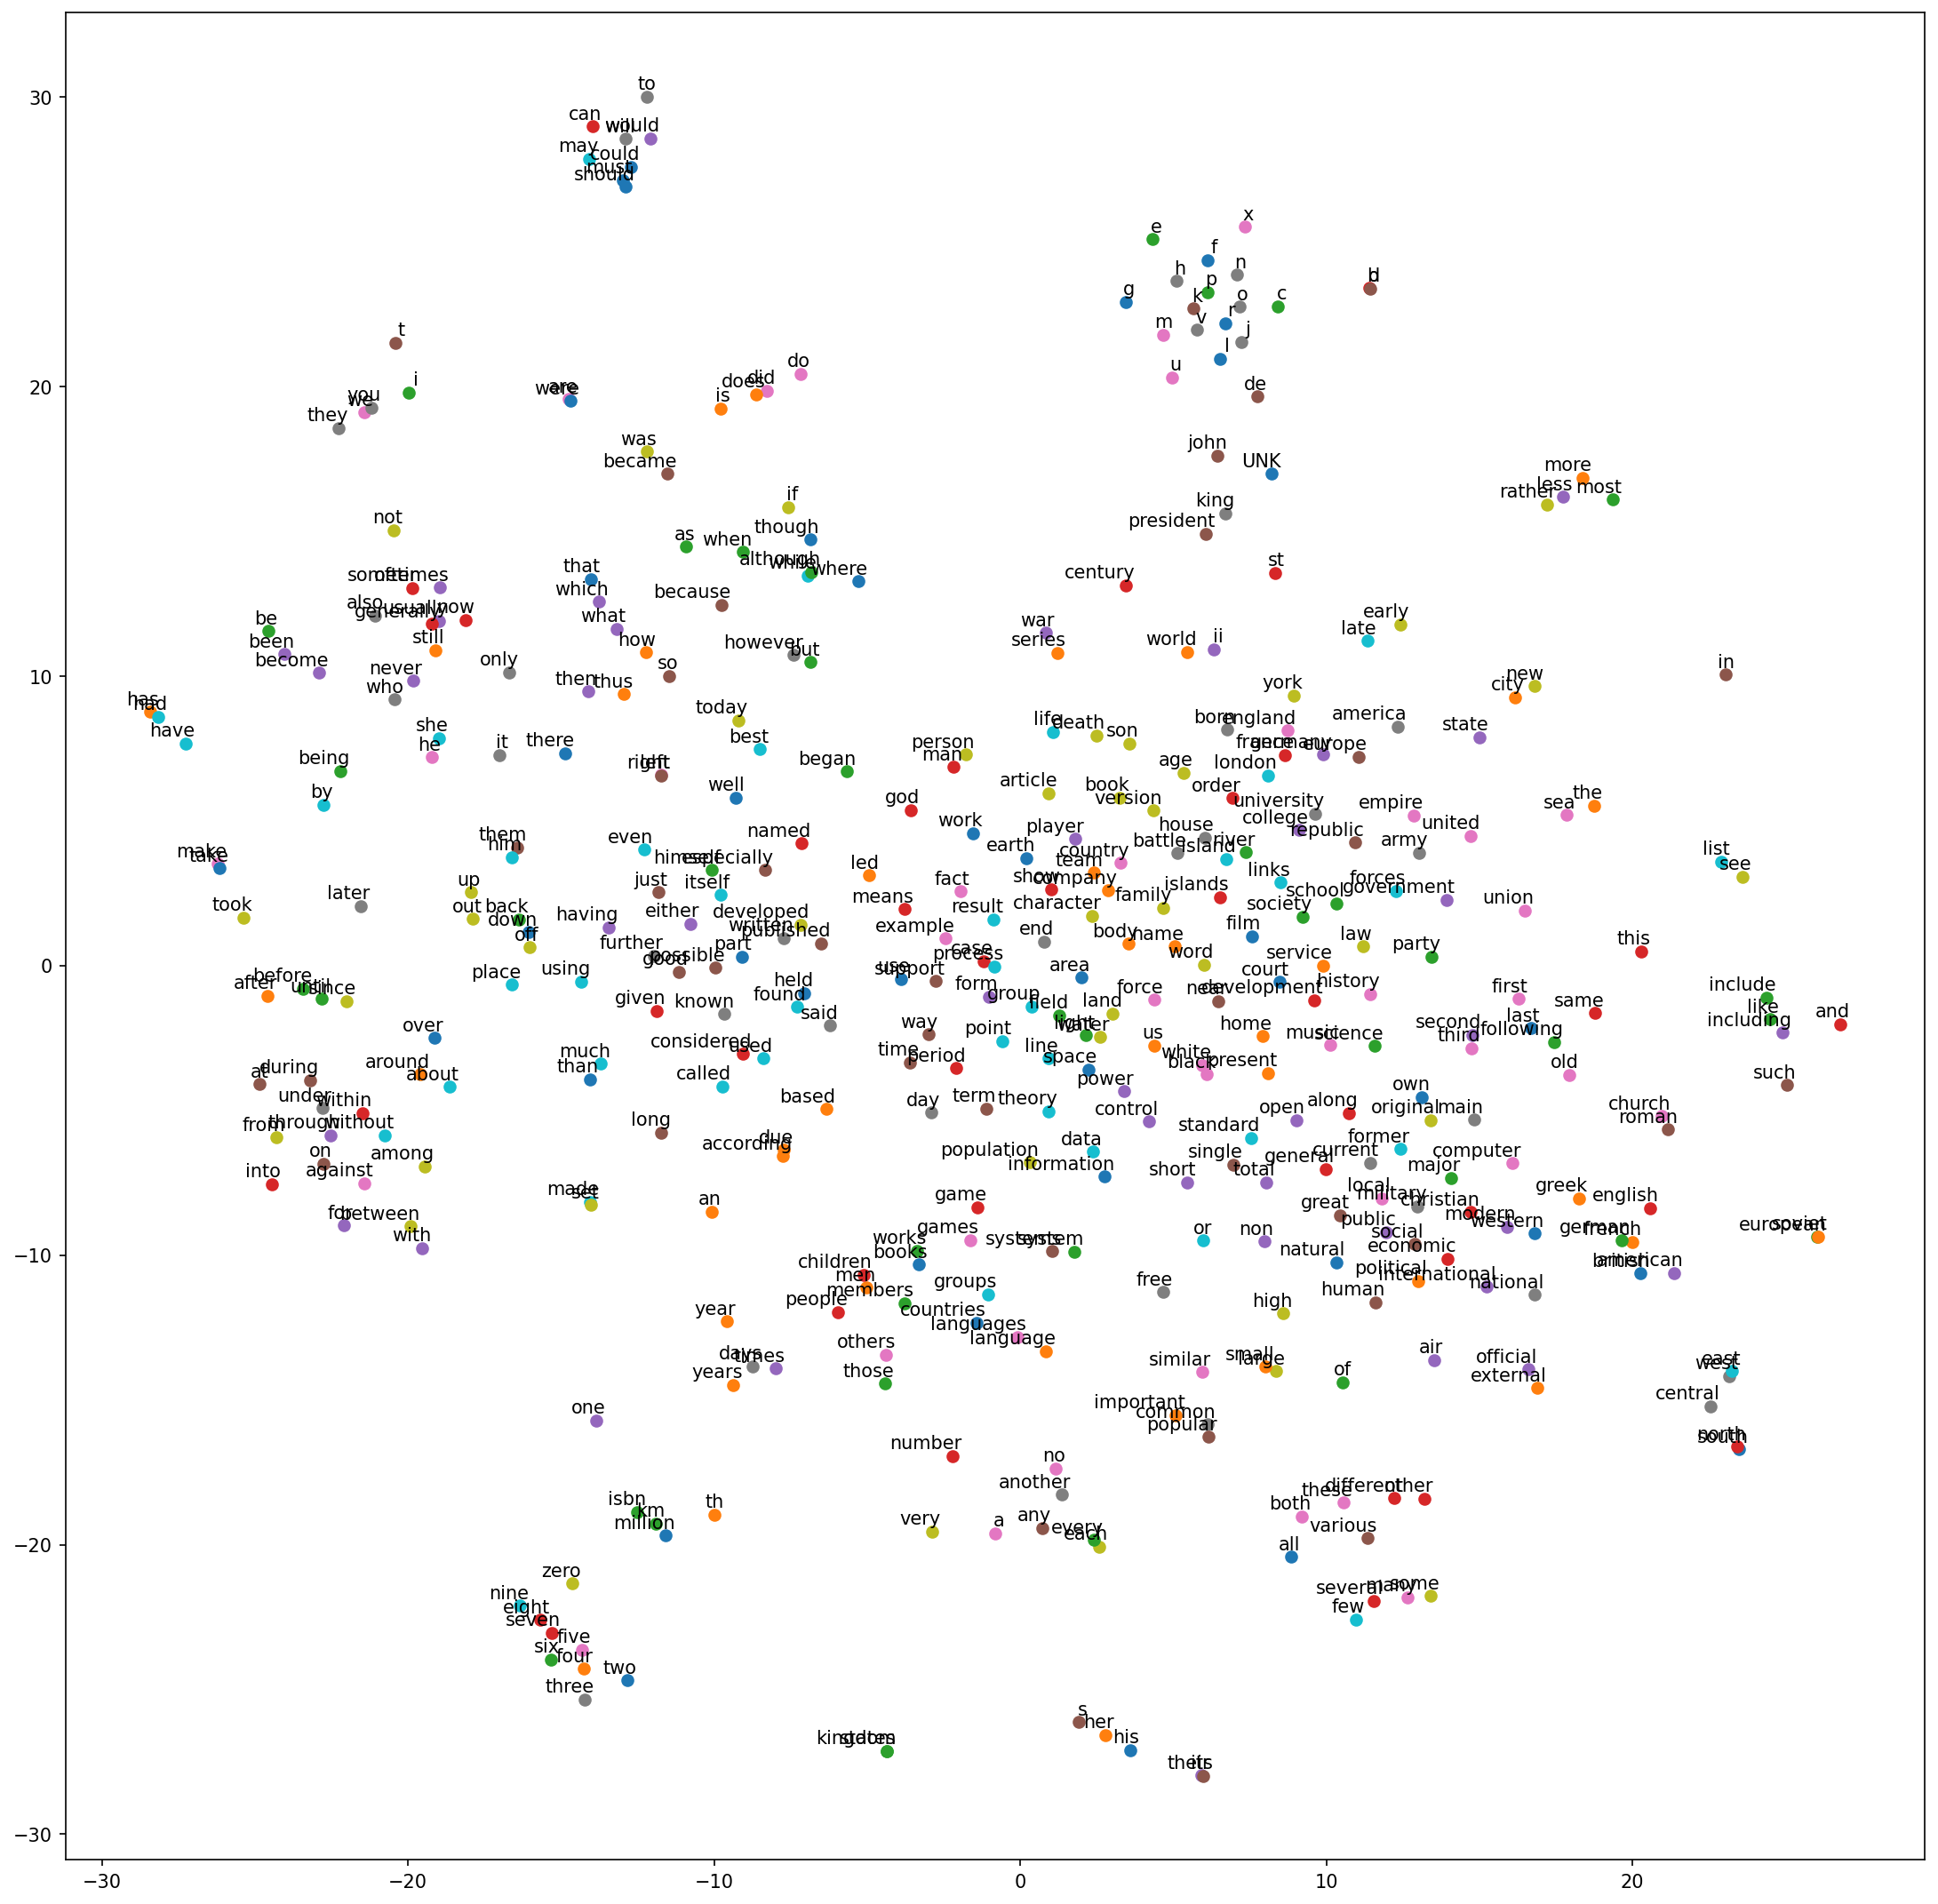

In [13]:
# get embedding matrix from model weights. > word2vec.weights[0]
embedding_matrix = word2vec.weights[0]


def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18), dpi=150)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords="offset points",
            ha="right",
            va="bottom",
        )


tsne = TSNE(
    perplexity=30,
    n_components=2,
    init="pca",
    n_iter=5000,
    method="exact",
    learning_rate="auto",
)
plot_only = 400
final_embeddings = embedding_matrix
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)


## Find top-5 nearest neighbors of two words.

Words: "will", "western"


In [14]:
# handy method for calculating the similarity between 2 word
def cos_sim(word1, word2):
    id1 = word_to_id[word1]
    id2 = word_to_id[word2]

    vec1 = embedding_matrix[id1].numpy()
    vec2 = embedding_matrix[id2].numpy()

    return np.dot(vec1, vec2) / (LA.norm(vec1) * LA.norm(vec2))


def top_k_nearest(word, k):
    vec = embedding_matrix[word_to_id[word]]

    # calaulate cosine similarity  of `vec` and all other vocabularies
    dot = np.dot(embedding_matrix.numpy(), vec)
    embedding_norm = LA.norm(embedding_matrix.numpy(), axis=-1)
    vec_norm = LA.norm(vec)
    norm_product = embedding_norm * vec_norm
    cos_sim = dot / norm_product

    # print out top k nearest words
    indices = np.argsort(cos_sim)[::-1][:k]
    print("---top {} nearest words of {}---".format(k, word))
    for idx in indices:
        print(id_to_word[idx])
    print("\n")


top_k_nearest("will", 5)
top_k_nearest("western", 5)


---top 5 nearest words of will---
will
could
would
must
should


---top 5 nearest words of western---
western
eastern
northern
southern
classical


